In [410]:
import pandas as pd
import numpy as np
import copy
from sklearn import linear_model, svm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import math
import missingno as msno
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [466]:
data = pd.read_csv("data/ODI-2021_trimmed.csv")
data = data.drop(columns=["Unnamed: 0", "Timestamp", "You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ", "What makes a good day for you (1)?", "What makes a good day for you (2)?"])

data = data[data['What is your gender?'] != 'unknown']

data['machine learning'] = LabelEncoder().fit_transform(data['Have you taken a course on machine learning?'])
data['info retrieval'] = LabelEncoder().fit_transform(data['Have you taken a course on information retrieval?'])
data['stats'] = LabelEncoder().fit_transform(data['Have you taken a course on statistics?'])
data['databases'] = LabelEncoder().fit_transform(data['Have you taken a course on databases?'])
data['gender'] = LabelEncoder().fit_transform(data['What is your gender?'])
data['chocolate'] = LabelEncoder().fit_transform(data['Chocolate makes you.....'])
data['neighbours'] = LabelEncoder().fit_transform(data['Number of neighbors sitting around you?'])
data['stand up?'] = LabelEncoder().fit_transform(data['Did you stand up?'])
data['stress'] = LabelEncoder().fit_transform(data['What is your stress level (0-100)?'])

# could add these, not needed and not really identifying?
bedtime_data = copy.deepcopy(data['Time you went to be Yesterday'])
# birthday = copy.deepcopy(data['When is your birthday (date)?']
# data['random'] = data['Give a random number']

# drop old colums
data = data.drop(columns=data.columns[1:13])

In [452]:
print(data.index)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            301, 302, 303, 304, 305, 306, 307, 308, 309, 310],
           dtype='int64', length=304)


In [454]:
program = copy.deepcopy(data["What programme are you in?"])

for i in data.index:
    prog = program[i]
    if "arti" in prog.lower():
        program[i] = "arti"
    elif "computer" in prog.lower():
        program[i] = "computer"
    elif "computational" in prog.lower():
        program[i] = "computational"
    elif "econometrics" in prog.lower():
        program[i] = "econometrics"
    elif "finan" in prog.lower():
        program[i] = "finan"
    elif "business" in prog.lower():
        program[i] = "business"
    elif "bio" in prog.lower():
        program[i] = "bio"
    elif "info" in prog.lower():
        program[i] = "info"
    elif "risk" in prog.lower():
        program[i] = "risk"
    elif "data" in prog.lower():
        program[i] = "data"
    else:
        program[i] = "other"

data["program"] = LabelEncoder().fit_transform(program)
data = data.drop(columns=["What programme are you in?"])

In [455]:
# make bedtime categorical
"""
early 13:00 - 20:00
middle 20:00 - 23:00
late 23:00 - 12:00
"""
bedtime = copy.deepcopy(bedtime_data)
for i in data.index:
    if not isinstance(bedtime[i], float):
        time = bedtime[i].split(":")
        time[0] = int(time[0])

        # check if answer should be changed to night time 
        if time[0] > 7 and time[0] < 13:
            time[0] = time[0] + 12
        elif time[0] == 0:
            time[0] = 24
        
        if time[0] >= 13 and time[0] < 21:
            bedtime[i] = "early"
        elif time[0] >= 21 and time[0] < 24:
            bedtime[i] = "middle"
        else:
            bedtime[i] = "late"
    else:
        bedtime[i] = "other"

data["bedtime"] = LabelEncoder().fit_transform(bedtime)

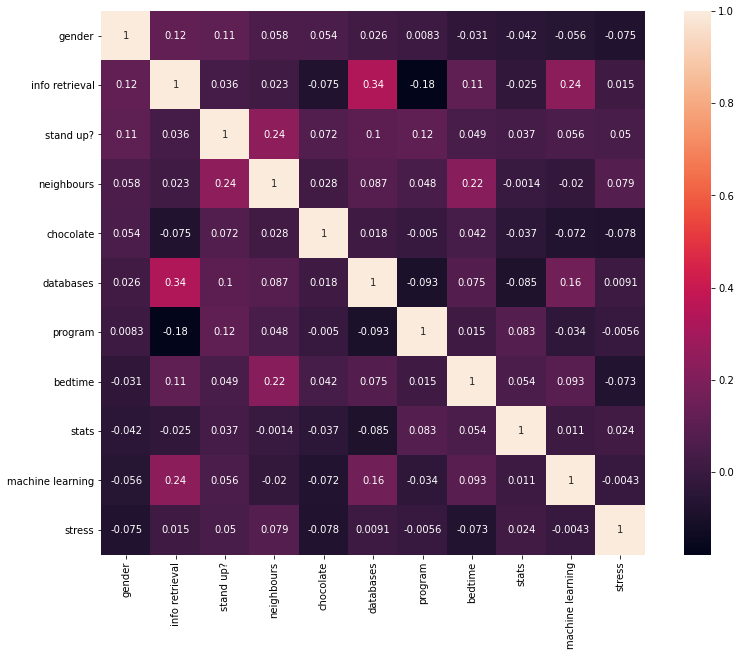

In [456]:
def make_corrmap(data, vactor):
    corrmat = data.corr()
    k = 20 #Number of variables for heat map with largest correlation.
    cols = corrmat.nlargest(k, vactor)[vactor].index
    f, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(data[cols].corr(), vmax=1, square=True, annot=True)
    f.savefig("data/corrmap.pdf")

make_corrmap(data, 'gender')

In [457]:
# Gridsearch with cross-validation
y = data["gender"]
x = data.drop(columns=['gender'])
parameters = {'C':np.arange(1.0, 5.1, 0.5)}
svc = svm.LinearSVC(dual=False)
print(svc.get_params().keys())

clf = GridSearchCV(svc, parameters)
clf.fit(x, y)

clf.best_params_

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])


{'C': 2.0}

In [460]:
# Take gender as target vector
y = data["gender"]
# x = data.drop(columns=['gender', 'stress', 'stand', 'neighbours', 'Stat', "ML", 'databases', 'IR', 'bedtime', 'chocolate'])
x = data.drop(columns=['gender',])

model = svm.LinearSVC(dual=False).fit(x, y)

# cross validate, pick 10% 10 times to evaluate
# 7-fold, this has been chosen because the predicter variable gender has 3 options. Yes, no and unknown
# Because unknown only occurs 7 times, it's only possible to go up to 7-fold cross validation.
pred = cross_val_score(model, x, y, cv=10)
y_pred = cross_val_predict(model, x, y, cv=10)
print(pred, "\nMean of cross-val:", np.mean(pred))

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

[0.67741935 0.64516129 0.67741935 0.64516129 0.7        0.66666667
 0.66666667 0.6        0.66666667 0.56666667] 
Mean of cross-val: 0.6511827956989247
[[  4  97]
 [  9 194]]
              precision    recall  f1-score   support

           0       0.31      0.04      0.07       101
           1       0.67      0.96      0.79       203

    accuracy                           0.65       304
   macro avg       0.49      0.50      0.43       304
weighted avg       0.55      0.65      0.55       304

0.6513157894736842


In [467]:
average = []
for _ in tqdm(range(100)):
    clf = RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=2, n_jobs=-1).fit(x, y)
    average.append(np.mean(cross_val_score(clf, x, y, cv=7)))

100%|██████████| 100/100 [09:14<00:00,  5.54s/it]


In [468]:
print(np.mean(average))

0.6783350951374209


In [461]:
clf = RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=2, n_jobs=-1).fit(x, y)

y_pred = cross_val_predict(clf, x, y, cv=10)
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))
print(accuracy_score(y, y_pred))

[[ 26  75]
 [ 24 179]]
              precision    recall  f1-score   support

           0       0.52      0.26      0.34       101
           1       0.70      0.88      0.78       203

    accuracy                           0.67       304
   macro avg       0.61      0.57      0.56       304
weighted avg       0.64      0.67      0.64       304

0.6743421052631579
